In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Import libraries**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


**2. Load the compressed dataset**

In [24]:
df = pd.read_csv("/content/drive/MyDrive/dataset_med.csv")
df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'], errors='coerce')
df['end_treatment_date'] = pd.to_datetime(df['end_treatment_date'], errors='coerce')
df['treatment_duration'] = (df['end_treatment_date'] - df['diagnosis_date']).dt.days
df.drop(columns=["id", "diagnosis_date", "end_treatment_date"], inplace=True)

In [25]:
df.describe()

,age,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,survived,treatment_duration
count,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000
mean,55.007008,30.494172,233.633916,0.750024,0.469740,0.225956,0.088157,0.220229,458.087170
std,9.994485,8.368539,43.432278,0.432999,0.499084,0.418211,0.283524,0.414401,139.326048
min,4.000000,16.000000,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,183.000000
25%,48.000000,23.300000,196.000000,1.000000,0.000000,0.000000,0.000000,0.000000,367.000000
50%,55.000000,30.500000,242.000000,1.000000,0.000000,0.000000,0.000000,0.000000,458.000000
75%,62.000000,37.700000,271.000000,1.000000,1.000000,0.000000,0.000000,0.000000,550.000000
max,104.000000,45.000000,300.000000,1.000000,1.000000,1.000000,1.000000,1.000000,730.000000


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   age                 890000 non-null  float64
 1   gender              890000 non-null  object 
 2   country             890000 non-null  object 
 3   cancer_stage        890000 non-null  object 
 4   family_history      890000 non-null  object 
 5   smoking_status      890000 non-null  object 
 6   bmi                 890000 non-null  float64
 7   cholesterol_level   890000 non-null  int64  
 8   hypertension        890000 non-null  int64  
 9   asthma              890000 non-null  int64  
 10  cirrhosis           890000 non-null  int64  
 11  other_cancer        890000 non-null  int64  
 12  treatment_type      890000 non-null  object 
 13  survived            890000 non-null  int64  
 14  treatment_duration  890000 non-null  int64  
dtypes: float64(2), int64(7), object(6)

In [27]:
df.head()

,age,gender,country,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,survived,treatment_duration
0,64.0,Male,Sweden,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,0,523
1,50.0,Female,Netherlands,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,1,424
2,65.0,Female,Hungary,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,0,370
3,51.0,Female,Belgium,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,0,443
4,37.0,Male,Luxembourg,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,0,406


In [28]:
df.tail()

,age,gender,country,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,survived,treatment_duration
889995,40.0,Male,Malta,Stage IV,No,Passive Smoker,44.8,243,1,1,1,0,Radiation,0,237
889996,62.0,Female,Cyprus,Stage II,Yes,Former Smoker,21.6,240,0,0,0,0,Surgery,0,631
889997,48.0,Female,Estonia,Stage III,Yes,Never Smoked,38.6,242,1,0,0,0,Combined,1,302
889998,67.0,Female,Slovakia,Stage IV,Yes,Former Smoker,18.6,194,1,1,0,0,Chemotherapy,0,721
889999,55.0,Female,Malta,Stage II,Yes,Current Smoker,42.8,250,0,0,0,0,Combined,0,450


/tmp/ipython-input-31-1772529798.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='cancer_stage', order=df['cancer_stage'].value_counts().index, palette='viridis')


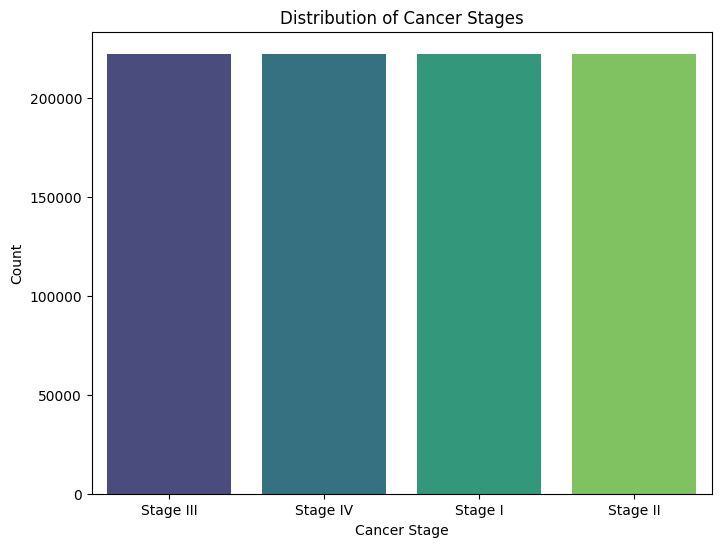

In [31]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='cancer_stage', order=df['cancer_stage'].value_counts().index, palette='viridis')
plt.title('Distribution of Cancer Stages')
plt.xlabel('Cancer Stage')
plt.ylabel('Count')
plt.show()

**3. Map binary values to readable labels**

In [17]:
df['survived'] = df['survived'].map({1: 1, 0: 0})
df['hypertension'] = df['hypertension'].map({1: 'Yes', 0: 'No'})
df['asthma'] = df['asthma'].map({1: 'Yes', 0: 'No'})
df['cirrhosis'] = df['cirrhosis'].map({1: 'Yes', 0: 'No'})
df['other_cancer'] = df['other_cancer'].map({1: 'Yes', 0: 'No'})

**4. Exploratory Data Analysis**

/tmp/ipython-input-18-1195122351.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='survived', palette='Set2')


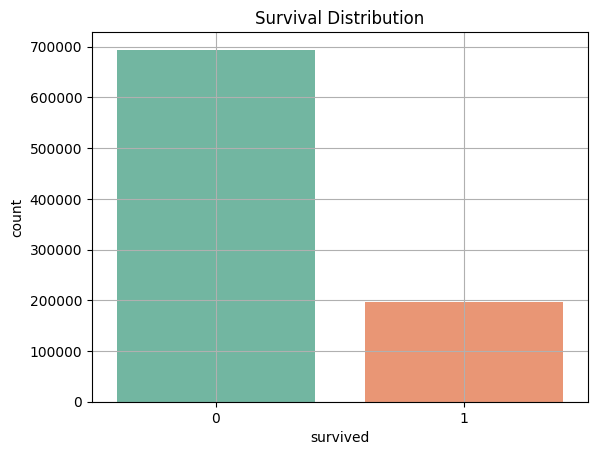

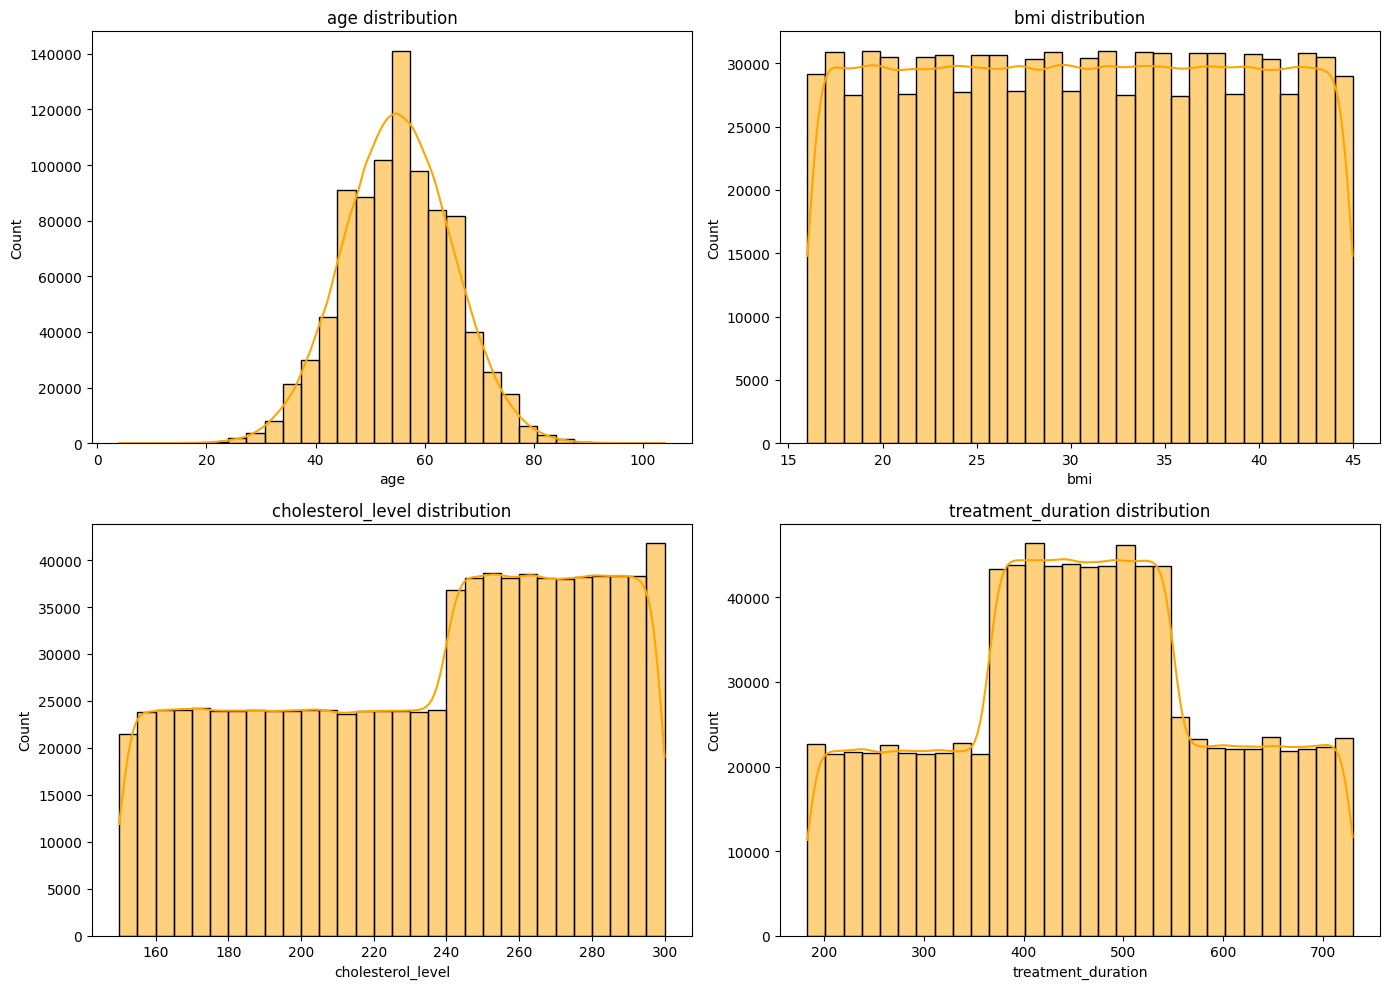

In [18]:

sns.countplot(data=df, x='survived', palette='Set2')
plt.title("Survival Distribution")
plt.grid(True)
plt.show()

numeric_features = ['age', 'bmi', 'cholesterol_level', 'treatment_duration']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, col in enumerate(numeric_features):
    sns.histplot(df[col], kde=True, ax=axes[i//2, i%2], bins=30, color='orange')
    axes[i//2, i%2].set_title(f"{col} distribution")
plt.tight_layout()
plt.show()


**5. Correlation Heatmap**

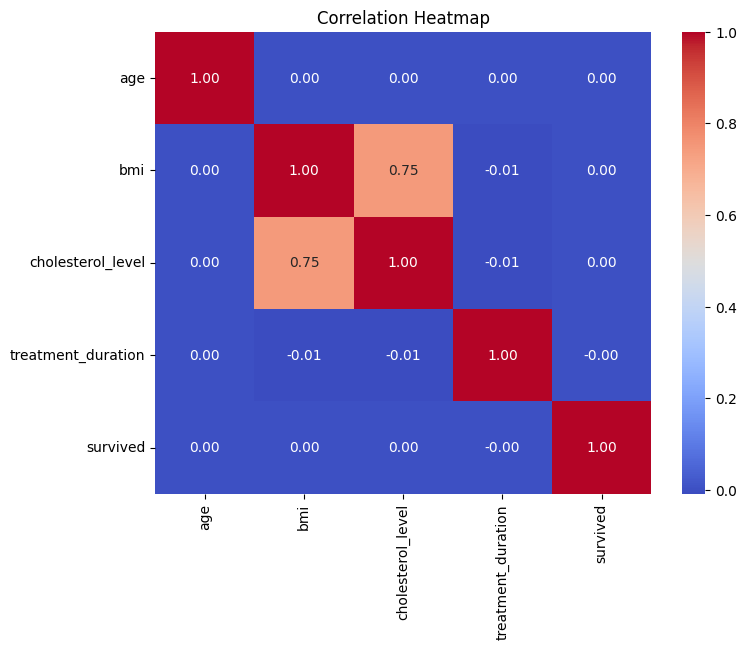

In [19]:
corr_df = df[numeric_features + ['survived']]
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


**6. Define features and target**

In [20]:

X = df.drop(columns='survived')
y = df['survived']

categorical_features = X.select_dtypes(include=['object']).columns.tolist()


**7. Preprocessing Pipelines**

In [21]:

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


**8. Logistic Regression Pipeline**

In [22]:

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, class_weight='balanced'))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi',
                                                   'cholesterol_level',
                                                   'treatment_duration']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'country',
                                                   'cancer_stage',
                                                   'family_history',
                                                   'smoking_status',
                                                   'hypertension', 'asthma',
                                                   'cirrhosis', 'other_cancer',
                                                   'treatment_type'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

**Evaluation**

In [23]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.48      0.60    138799
           1       0.22      0.52      0.31     39201

    accuracy                           0.49    178000
   macro avg       0.50      0.50      0.45    178000
weighted avg       0.66      0.49      0.53    178000

Confusion Matrix:
 [[66983 71816]
 [18938 20263]]
ROC AUC Score: 0.49973500428110273
